# MMSegmentation Tutorial
Welcome to MMSegmentation!

In this tutorial, we demo
* How to do inference with MMSeg trained weight
* How to train on your own dataset and visualize the results.

## Install MMSegmentation
This step may take several minutes.

We use PyTorch 1.12 and CUDA 11.3 for this tutorial. You may install other versions by change the version number in pip install command.

In [ ]:
# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
gcc (Ubuntu 9.4.0-1ubuntu1~20.04.1) 9.4.0
Copyright (C) 2019 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [ ]:
!pip3 install openmim
!mim install mmengine
!mim install "mmcv>=2.0.0"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.3/51.3 kB 3.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.openmmlab.com/mmcv/dist/cu118/torch2.0.0/index.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.3/374.3 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.3/250.3 kB 26.9 MB/s eta 0:00:00
  Attempting uninstall: platformdirs
    Found existing installation: platformdirs 3.3.0
    Uninstalling platformdirs-3.3.0:
      Successfully uninstalled platformdirs-3.3.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.openmmlab.com/mmcv/dist/cu118/torch2.0.0/index.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.4/74.4 MB 8.8 MB/s eta 0:00:00


In [ ]:
!git clone https://github.com/open-mmlab/mmsegmentation.git
%cd mmsegmentation
!git checkout main
!pip install -e .

Cloning into 'mmsegmentation'...
remote: Enumerating objects: 15132, done.
remote: Counting objects: 100% (698/698), done.
remote: Compressing objects: 100% (474/474), done.
remote: Total 15132 (delta 281), reused 429 (delta 192), pack-reused 14434
Receiving objects: 100% (15132/15132), 20.71 MiB | 23.40 MiB/s, done.
Resolving deltas: 100% (10586/10586), done.
/content/mmsegmentation
Already on 'main'
Your branch is up to date with 'origin/main'.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/mmsegmentation
  Preparing metadata (setup.py) ... done
  Running setup.py develop for mmsegmentation


In [ ]:
import mmseg
print(mmseg.__version__)
# 示例输出: 1.0.0

1.0.0


## Finetune a semantic segmentation model on a new dataset

To finetune on a customized dataset, the following steps are necessary.
1. Add a new dataset class.
2. Create a config file accordingly.
3. Perform training and evaluation.

### Add a new dataset

Datasets in MMSegmentation require image and semantic segmentation maps to be placed in folders with the same prefix. To support a new dataset, we may need to modify the original file structure.

In this tutorial, we give an example of converting the dataset. You may refer to [docs](https://github.com/open-mmlab/mmsegmentation/blob/master/docs/en/tutorials/customize_datasets.md#customize-datasets-by-reorganizing-data) for details about dataset reorganization.

We use [Stanford Background Dataset](http://dags.stanford.edu/projects/scenedataset.html) as an example. The dataset contains 715 images chosen from existing public datasets [LabelMe](http://labelme.csail.mit.edu), [MSRC](http://research.microsoft.com/en-us/projects/objectclassrecognition), [PASCAL VOC](http://pascallin.ecs.soton.ac.uk/challenges/VOC) and [Geometric Context](http://www.cs.illinois.edu/homes/dhoiem/). Images from these datasets are mainly outdoor scenes, each containing approximately 320-by-240 pixels.
In this tutorial, we use the region annotations as labels. There are 8 classes in total, i.e. sky, tree, road, grass, water, building, mountain, and foreground object.

In [ ]:
# download and unzip
!wget https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20230130-mmseg/dataset/watermelon/Watermelon87_Semantic_Seg_Mask.zip -O Watermelon87_Semantic_Seg_Mask.zip
!unzip Watermelon87_Semantic_Seg_Mask.zip

--2023-06-18 03:23:29--  https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20230130-mmseg/dataset/watermelon/Watermelon87_Semantic_Seg_Mask.zip
Resolving zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com (zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com)... 121.36.235.132
Connecting to zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com (zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com)|121.36.235.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13230222 (13M) [application/zip]
Saving to: ‘Watermelon87_Semantic_Seg_Mask.zip’

Watermelon87_Semant 100%[===================>]  12.62M  5.28MB/s    in 2.4s    

2023-06-18 03:23:33 (5.28 MB/s) - ‘Watermelon87_Semantic_Seg_Mask.zip’ saved [13230222/13230222]

Archive:  Watermelon87_Semantic_Seg_Mask.zip
   creating: Watermelon87_Semantic_Seg_Mask/
   creating: Watermelon87_Semantic_Seg_Mask/img_dir/
   creating: Watermelon87_Semantic_Seg_Mask/img_dir/train/
  inflating: Watermelon87_Semantic_Seg_Mask/img_dir/train/IM

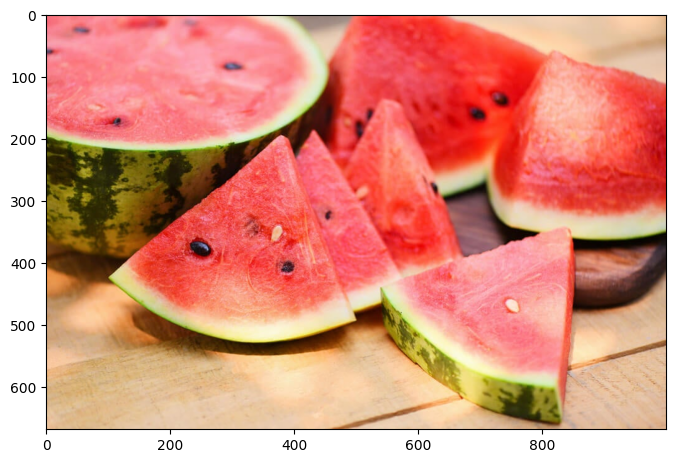

In [ ]:
# Let's take a look at the dataset
import mmcv
import mmengine
import matplotlib.pyplot as plt


img = mmcv.imread('Watermelon87_Semantic_Seg_Mask/img_dir/train/04_35-2.jpg')
plt.figure(figsize=(8, 6))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

We need to convert the annotation into semantic map format as an image.

In [ ]:
# define dataset root and directory for images and annotations
data_root = 'Watermelon87_Semantic_Seg_Mask'
img_dir = 'img_dir'
ann_dir = 'ann_dir'
# define class and palette for better visualization
classes = ('background', 'red', 'green', 'white', 'seed-black', 'seed-white')
palette = [[51, 204, 204], [255, 0, 51], [34, 221, 34], [221, 221, 221], [0, 0, 0], [128, 128, 128]]

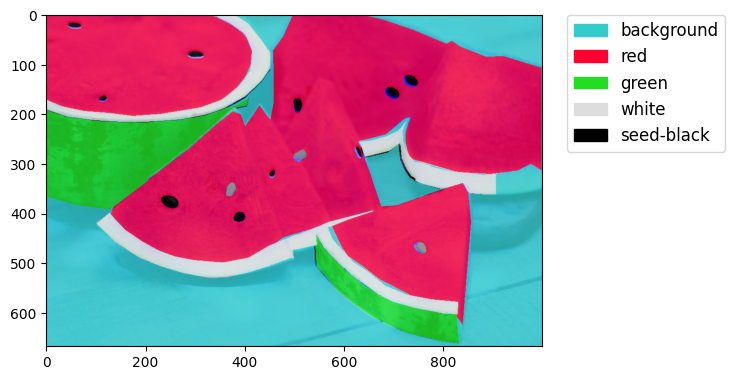

In [ ]:
# Let's take a look at the segmentation map we got
import mmcv
import os.path as osp
import torch
import matplotlib.patches as mpatches
from PIL import Image
import numpy as np

# `PixelData` 是 MMEngine 中用于定义像素级标注或预测的数据结构。
# 请参考下面的MMEngine数据结构教程文件：
# https://mmengine.readthedocs.io/zh_CN/latest/advanced_tutorials/data_element.html#pixeldata

from mmengine.structures import PixelData

# `SegDataSample` 是在 MMSegmentation 中定义的不同组件之间的数据结构接口，
# 它包括 ground truth、语义分割的预测结果和预测逻辑。
# 详情请参考下面的 `SegDataSample` 教程文件：
# https://github.com/open-mmlab/mmsegmentation/blob/1.x/docs/en/advanced_guides/structures.md

from mmseg.structures import SegDataSample
from mmseg.visualization import SegLocalVisualizer

out_file = 'out_file'
save_dir = './work_dirs'

image = mmcv.imread('./Watermelon87_Semantic_Seg_Mask/img_dir/train/04_35-2.jpg', 'color')
sem_seg = mmcv.imread('./Watermelon87_Semantic_Seg_Mask/ann_dir/train/04_35-2.png', 'unchanged')
sem_seg = torch.from_numpy(sem_seg)
gt_sem_seg_data = dict(data=sem_seg)
gt_sem_seg = PixelData(**gt_sem_seg_data)
data_sample = SegDataSample()
data_sample.gt_sem_seg = gt_sem_seg

seg_local_visualizer = SegLocalVisualizer(
    vis_backends=[dict(type='LocalVisBackend')],
    save_dir=save_dir)

# 数据集的元信息通常包括类名的 `classes` 和
# 用于可视化每个前景颜色的 `palette` 。
# 所有类名和调色板都在此文件中定义：
# https://github.com/open-mmlab/mmsegmentation/blob/1.x/mmseg/utils/class_names.py

seg_local_visualizer.dataset_meta = dict(
    classes=classes,
    palette=palette)

# 当`show=True`时，直接显示结果，
# 当 `show=False`时，结果将保存在本地文件夹中。

seg_local_visualizer.add_datasample(out_file, image, data_sample, show=False)
im = plt.imshow(np.array(Image.open("./work_dirs/vis_data/vis_image/out_file_0.png").convert('RGB')))
# create a patch (proxy artist) for every color
patches = [mpatches.Patch(color=np.array(palette[i])/255., label=classes[i]) for i in range(5)]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize='large')

plt.show()

After downloading the data, we need to implement `load_annotations` function in the new dataset class `StanfordBackgroundDataset`.

In [ ]:
from mmseg.registry import DATASETS
from mmseg.datasets import BaseSegDataset


@DATASETS.register_module()
class StanfordBackgroundDataset(BaseSegDataset):
  METAINFO = dict(classes = classes, palette = palette)
  def __init__(self, **kwargs):
    super().__init__(img_suffix='.jpg', seg_map_suffix='.png', **kwargs)


### Create a config file
In the next step, we need to modify the config for the training. To accelerate the process, we finetune the model from trained weights.

In [ ]:
# Download config and checkpoint files
!mim download mmsegmentation --config pspnet_r50-d8_4xb2-40k_cityscapes-512x1024 --dest .

processing pspnet_r50-d8_4xb2-40k_cityscapes-512x1024...
downloading ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.1/187.1 MiB 64.2 MB/s eta 0:00:00
Successfully downloaded pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth to /content/mmsegmentation
Successfully dumped pspnet_r50-d8_4xb2-40k_cityscapes-512x1024.py to /content/mmsegmentation


In [ ]:
from mmengine import Config
cfg = Config.fromfile('configs/pspnet/pspnet_r50-d8_4xb2-40k_cityscapes-512x1024.py')
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='SyncBN', requires_grad=True)
data_preprocessor = dict(
    type='SegDataPreProcessor',
    mean=[123.675, 116.28, 103.53],
    std=[58.395, 57.12, 57.375],
    bgr_to_rgb=True,
    pad_val=0,
    seg_pad_val=255,
    size=(512, 1024))
model = dict(
    type='EncoderDecoder',
    data_preprocessor=dict(
        type='SegDataPreProcessor',
        mean=[123.675, 116.28, 103.53],
        std=[58.395, 57.12, 57.375],
        bgr_to_rgb=True,
        pad_val=0,
        seg_pad_val=255,
        size=(512, 1024)),
    pretrained='open-mmlab://resnet50_v1c',
    backbone=dict(
        type='ResNetV1c',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        dilations=(1, 1, 2, 4),
        strides=(1, 2, 1, 1),
        norm_cfg=dict(type='SyncBN', requires_grad=True),
        norm_eval=False,
        style='pytorch',
        contract_dilation=True),
    decode_head=dict(
        type='PSPHead',
        in_channels=2048,
        in_index=3,

Since the given config is used to train PSPNet on the cityscapes dataset, we need to modify it accordingly for our new dataset.

In [ ]:
# Since we use only one GPU, BN is used instead of SyncBN
cfg.norm_cfg = dict(type='BN', requires_grad=True)
cfg.model.data_preprocessor.size = cfg.crop_size
cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg
# modify num classes of the model in decode/auxiliary head
cfg.model.decode_head.num_classes = 6
cfg.model.auxiliary_head.num_classes = 6

# Modify dataset type and path
cfg.dataset_type = 'StanfordBackgroundDataset'
cfg.data_root = data_root

cfg.train_dataloader.batch_size = 4
cfg.val_dataloader.num_workers = 2

cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='RandomResize', scale=(2048, 1024), ratio_range=(0.5, 2.0), keep_ratio=True),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', prob=0.5),
    dict(type='PackSegInputs')
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='Resize', scale=(2048, 1024), keep_ratio=True),
    # add loading annotation after ``Resize`` because ground truth
    # does not need to do resize data transform
    dict(type='LoadAnnotations'),
    dict(type='PackSegInputs')
]


cfg.train_dataloader.dataset.type = cfg.dataset_type
cfg.train_dataloader.dataset.data_root = cfg.data_root
cfg.train_dataloader.dataset.data_prefix = dict(img_path=osp.join(img_dir, 'train'),
                         seg_map_path=osp.join(ann_dir, 'train'))
cfg.train_dataloader.dataset.pipeline = cfg.train_pipeline

cfg.val_dataloader.dataset.type = cfg.dataset_type
cfg.val_dataloader.dataset.data_root = cfg.data_root
cfg.val_dataloader.dataset.data_prefix = dict(img_path=osp.join(img_dir, 'val'),
                        seg_map_path=osp.join(ann_dir, 'val'))
cfg.val_dataloader.dataset.pipeline = cfg.test_pipeline

cfg.test_dataloader = cfg.val_dataloader


# Load the pretrained weights
cfg.load_from = 'pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './work_dirs/tutorial'

cfg.train_cfg.max_iters = 300
cfg.train_cfg.val_interval = 10
cfg.default_hooks.logger.interval = 1
cfg.default_hooks.checkpoint.interval = 300
cfg.default_hooks.checkpoint.save_best = 'auto'

# Set seed to facilitate reproducing the result
cfg['randomness'] = dict(seed=0)

# Save the changed config
with open('./pspnet_r50-d8_4xb2-40k_cityscapes-512x1024_changed.py', 'w') as f:
  f.write(Config.dump(cfg))

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='BN', requires_grad=True)
data_preprocessor = dict(
    type='SegDataPreProcessor',
    mean=[123.675, 116.28, 103.53],
    std=[58.395, 57.12, 57.375],
    bgr_to_rgb=True,
    pad_val=0,
    seg_pad_val=255,
    size=(512, 1024))
model = dict(
    type='EncoderDecoder',
    data_preprocessor=dict(
        type='SegDataPreProcessor',
        mean=[123.675, 116.28, 103.53],
        std=[58.395, 57.12, 57.375],
        bgr_to_rgb=True,
        pad_val=0,
        seg_pad_val=255,
        size=(512, 1024)),
    pretrained='open-mmlab://resnet50_v1c',
    backbone=dict(
        type='ResNetV1c',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        dilations=(1, 1, 2, 4),
        strides=(1, 2, 1, 1),
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=False,
        style='pytorch',
        contract_dilation=True),
    decode_head=dict(
        type='PSPHead',
        in_channels=2048,
        in_index=3,
       

### Train and Evaluation

In [ ]:
from mmengine.runner import Runner

runner = Runner.from_cfg(cfg)

06/18 02:32:05 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.12 (main, Jun  7 2023, 12:45:35) [GCC 9.4.0]
    CUDA available: True
    numpy_random_seed: 0
    GPU 0: Tesla T4
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 11.8, V11.8.89
    GCC: x86_64-linux-gnu-gcc (Ubuntu 9.4.0-1ubuntu1~20.04.1) 9.4.0
    PyTorch: 2.0.1+cu118
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2022.2-Product Build 20220804 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.7.3 (Git Hash 6dbeffbae1f23cbbeae17adb7b5b13f1f37c080e)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.8
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_

/usr/local/lib/python3.10/dist-packages/mmengine/utils/manager.py:113: UserWarning: <class 'mmseg.visualization.local_visualizer.SegLocalVisualizer'> instance named of visualizer has been created, the method `get_instance` should not accept any other arguments
  warnings.warn(
/content/mmsegmentation/mmseg/models/backbones/resnet.py:431: UserWarning: DeprecationWarning: pretrained is a deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is a deprecated, '
/content/mmsegmentation/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/content/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:235: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ig

06/18 02:32:06 - mmengine - INFO - Distributed training is not used, all SyncBatchNorm (SyncBN) layers in the model will be automatically reverted to BatchNormXd layers if they are used.
06/18 02:32:06 - mmengine - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) RuntimeInfoHook                    
(BELOW_NORMAL) LoggerHook                         
 -------------------- 
before_train:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(VERY_LOW    ) CheckpointHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(NORMAL      ) DistSamplerSeedHook                
 -------------------- 
before_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
 -------------------- 
after_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                

/content/mmsegmentation/mmseg/engine/hooks/visualization_hook.py:61: UserWarning: The draw is False, it means that the hook for visualization will not take effect. The results will NOT be visualized or stored.
  warnings.warn('The draw is False, it means that the '


In [ ]:
# start training
runner.train()

06/18 02:32:11 - mmengine - WARNING - The prefix is not set in metric class IoUMetric.
06/18 02:32:12 - mmengine - INFO - load model from: open-mmlab://resnet50_v1c
06/18 02:32:12 - mmengine - INFO - Loads checkpoint by openmmlab backend from path: open-mmlab://resnet50_v1c
06/18 02:32:12 - mmengine - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: fc.weight, fc.bias

Loads checkpoint by local backend from path: pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([19, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([6, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([19]) from checkpoint, the shape in current model is torch.Size([6]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape tor

EncoderDecoder(
  (data_preprocessor): SegDataPreProcessor()
  (backbone): ResNetV1c(
    (stem): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU(inplace=True)
    )
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): ResLayer(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-0

Inference with trained model

/content/mmsegmentation/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/content/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:235: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: ./work_dirs/tutorial/best_aAcc_iter_240.pth
06/18 02:58:41 - mmengine - WARNING - `Visualizer` backend is not initialized because save_dir is None.


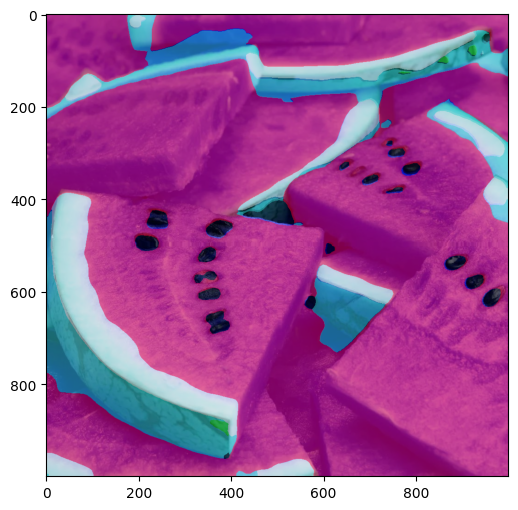

In [ ]:
from mmseg.apis import init_model, inference_model, show_result_pyplot

# Init the model from the config and the checkpoint
checkpoint_path = './work_dirs/tutorial/best_aAcc_iter_240.pth'
model = init_model(cfg, checkpoint_path, 'cuda:0')

img = mmcv.imread('./Watermelon87_Semantic_Seg_Mask/bb83d3ba048873c6d9b724455116cbc6.jpeg')
result = inference_model(model, img)
plt.figure(figsize=(8, 6))
vis_result = show_result_pyplot(model, img, result)
plt.imshow(vis_result)
